# Setup

This Jupyter notebook uses the necessary Python packages to connect to a Redshift database and execute queries in .SQL files in the 'queries' directory. Each question in the assessment is listed with a print_query call to show the script to be run against the db. I present in this format as it would be easy for a colleague to  add their own sql files to the directory and quickly begin analyses without having to change much of the notebook.

To run the queries and view the results requires some setup steps:
- It is recommended to use a virtual environment, like venv
- In your terminal, change working directory to the root of this repo and run 'pip install -r requirements.txt' to install dependencies
- Execute the IMPORT block below
- Execute the 3 METHODS blocks below; this includes the start_engine method to create the connection to the Redshift db

## Import

In [180]:
import matplotlib.pyplot as plt
import pandas as pd

# SQLAlchemy is the ideal package for connecting to redshift RDMS as it is better supported by pandas; read, doesn't throw the 'unsupported' warning
import sqlalchemy as sa
from sqlalchemy.engine.url import URL
from sqlalchemy import orm as sa_orm

## Methods

In [170]:
# build the sqlalchemy URL
def start_engine():
    url = URL.create(
    drivername='redshift+redshift_connector', # indicate redshift_connector driver and dialect will be used
    host='analyst-assignment.ckgrmpwkfuaa.us-west-2.redshift.amazonaws.com', # Amazon Redshift host
    port=5439, # Amazon Redshift port
    database='assignment', # Amazon Redshift database
    username='awsuser', # Amazon Redshift username
    password='tbloxsom1234A' # Amazon Redshift password
    )
    engine = sa.create_engine(url)
    Session = sa_orm.sessionmaker()
    Session.configure(bind=engine)
    return engine

In [171]:
def print_query(file_path):
    f = open(file_path, 'r')
    file_contents = f.read()
    print (file_contents)

In [172]:
#
def execute_query(file_path):
    engine = sa.create_engine(url)
    Session = sa_orm.sessionmaker()
    Session.configure(bind=engine)

    # Read SQL code from .sql file
    with open(file_path, "r") as file:
        sql = file.read()

    # Execute SQL code and load results into a pandas dataframe
    df = pd.read_sql(sql, engine)

    # Close connection
    engine.dispose()
    return df

# Questions

### *Which are the top 10 account ids by number of users?*

In [173]:
print_query('queries/top10.sql')

SELECT
    account_id,
    COUNT(DISTINCT user_id) AS num_users
FROM public.tasks_used_da
GROUP BY account_id
ORDER BY num_users DESC
LIMIT 10;


In [193]:
execute_query('queries/top10.sql')

,account_id,num_users
0,-1,3614
1,2101269,116
2,2074697,44
3,2147969,20
4,2284259,18
5,1215768,17
6,1675574,15
7,2187586,13
8,2165388,11
9,2258002,9


### *Create a summary table at the account level that signals when an account is new (boolean). An account is new for the first day we see it run a task(s).*

In [ ]:
print_query('queries/first_account.sql')

In [ ]:
create_table_new_accounts=execute_query('queries/new_accounts.sql')
create_table_new_accounts

### *Add another column with the moving average of the tasks run in the last 7 days for each account.*

In [186]:
print_query('queries/seven_day_avg.sql')

SELECT
    account_id,
    date,
    sum_tasks_used,
    AVG(sum_tasks_used) OVER (PARTITION BY account_id ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS seven_day_running_average
FROM
    public.tasks_used_da;



In [187]:
seven_day_avg=execute_query('queries/seven_day_avg.sql')
seven_day_avg

,account_id,date,sum_tasks_used,seven_day_running_average
0,-1,2017-01-01,8,8
1,-1,2017-01-01,1,4
2,-1,2017-01-01,1,3
3,-1,2017-01-01,1,2
4,-1,2017-01-01,2,2
...,...,...,...,...
10547582,2880897,2017-05-22,8,7
10547583,2880897,2017-05-26,10,8
10547584,2880897,2017-05-30,15,6
10547585,2880897,2017-05-31,2,6


### *Create a summary table at the account level. Add a column with the % difference in the number of tasks to the previous day*

In [188]:
print_query('queries/seven_day_avg_and_daily_pct_chg.sql')

WITH cte AS (
    SELECT
        date,
        account_id,
        sum_tasks_used,
        SUM(sum_tasks_used) OVER (PARTITION BY account_id ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS seven_day_running_avg,
        LAG(sum_tasks_used) OVER (PARTITION BY account_id ORDER BY date) AS prev_sum_tasks_used
    FROM public.tasks_used_da
),
     cte2 AS (
         SELECT
             date,
             account_id,
             sum_tasks_used,
             seven_day_running_avg,
             CASE
                 WHEN prev_sum_tasks_used = 0 THEN 0
                 ELSE (sum_tasks_used - prev_sum_tasks_used) / prev_sum_tasks_used
                 END AS percent_change
         FROM cte
     )
SELECT
    date,
    account_id,
    sum_tasks_used,
    seven_day_running_avg,
    percent_change
FROM cte2
ORDER BY date, account_id;


In [189]:
start_engine()
pct_change=execute_query('queries/seven_day_avg_and_daily_pct_chg.sql')
pct_change

,date,account_id,sum_tasks_used,seven_day_running_avg,percent_change
0,2017-01-01,-1,8,8,7.0
1,2017-01-01,-1,1,9,0.0
2,2017-01-01,-1,1,10,0.0
3,2017-01-01,-1,1,11,0.0
4,2017-01-01,-1,2,13,1.0
...,...,...,...,...,...
10547582,2017-06-01,2880897,6,45,2.0
10547583,2017-06-01,3016718,38,543,0.0
10547584,2017-06-01,3016718,168,661,4.0
10547585,2017-06-01,3016718,33,593,1.0


### *A lost account is an account with no tasks run on a given month. How many accounts did we lose (had no executed tasks) in February 2017?*

In [190]:
print_query('queries/lost_accts.sql')

WITH cte AS (
    SELECT
        date,
        account_id,
        sum_tasks_used
    FROM public.tasks_used_da
    WHERE date BETWEEN '2017-02-01' AND '2017-02-28'
),
     cte2 AS (
         SELECT DISTINCT account_id
         FROM cte
     )
SELECT
    COUNT(*) AS total_lost_accounts
FROM public.tasks_used_da
WHERE date BETWEEN '2017-01-01' AND '2017-01-31'
  AND account_id NOT IN (SELECT account_id FROM cte2);


In [191]:
start_engine()
lost_accounts=execute_query('queries/lost_accts.sql')
lost_accounts

,total_lost_accounts
0,134966


### *(OPTIONAL) Create a visualization that represents the growth of new accounts in a way you would communicate to a peer or business stakeholder*

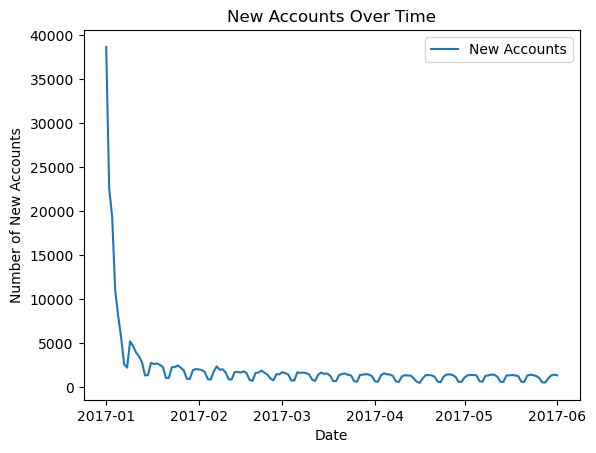

In [192]:
start_engine()

# Fetch data for new accounts


query = "SELECT date, count(account_id) as new_accounts FROM first_account_tasks WHERE is_new = 't' GROUP BY date ORDER BY date"
new_accounts = pd.read_sql(query, engine)

# Plot line chart of new accounts growth
plt.plot(new_accounts['date'], new_accounts['new_accounts'], label='New Accounts')
plt.xlabel('Date')
plt.ylabel('Number of New Accounts')
plt.title('New Accounts Over Time')
plt.legend()
plt.show()
